In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path 
from datetime import datetime 

import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

from rowing.analysis import geodesy, files, splits, garmin, utils

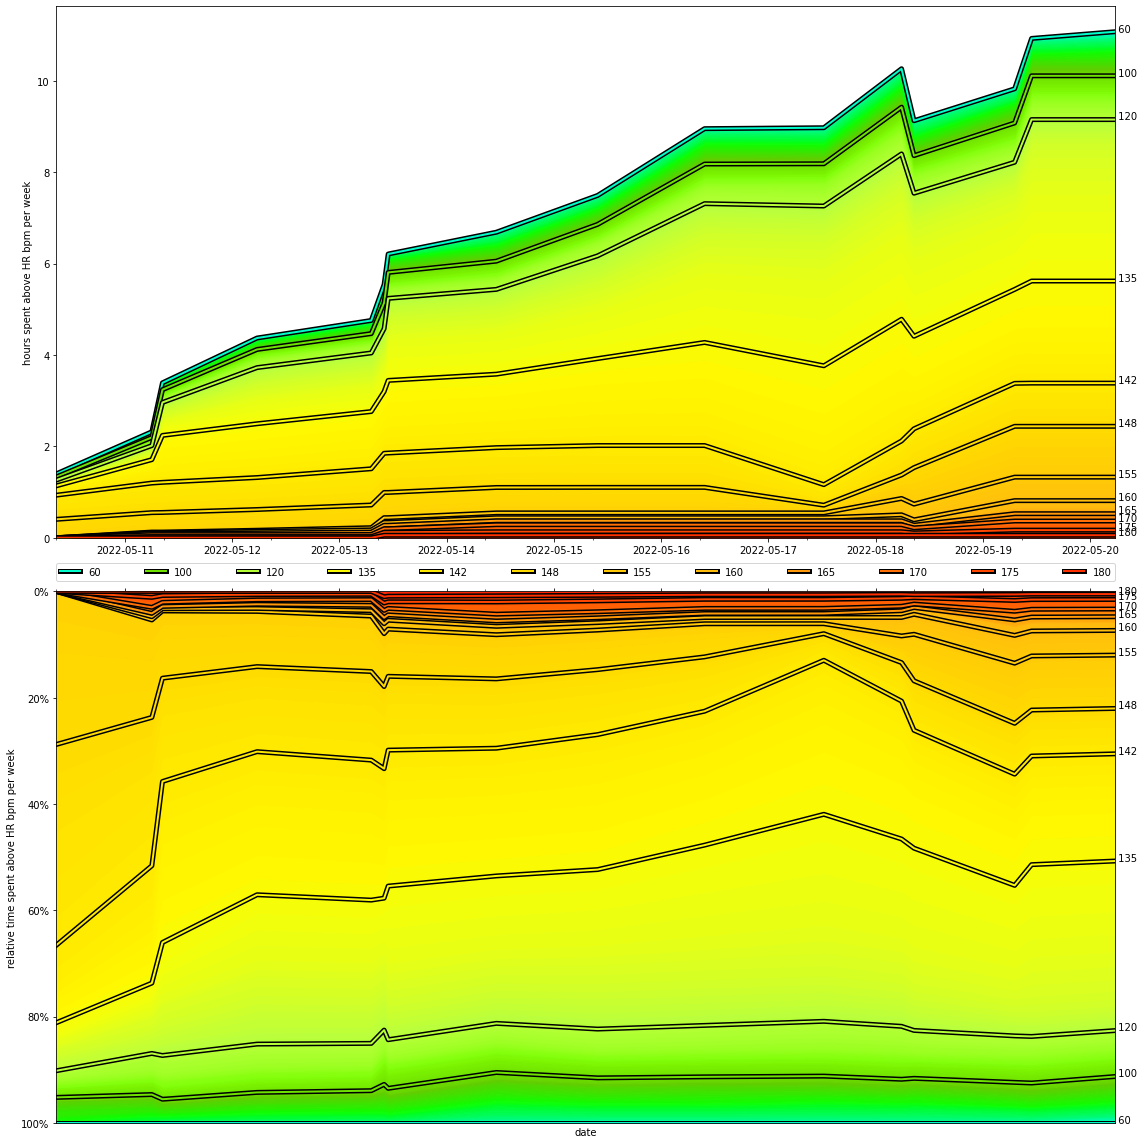

In [3]:
activities = garmin.run([
    '20', 
    '--credentials=garmin-credentials.json',
    # '--action=download',
    "--action", "heartrate", "excel", 
    "--start-date", "2022-05-10",
    "--end-date", "2022-05-20",
    # '--folder=test_folder', 
    '--logging=WARNING', 
])

In [4]:
api = garmin.login(credentials='garmin-credentials.json')
folder = Path("garmin_data")
save_file = Path(folder) / "activities.parquet"
save_file  

PosixPath('garmin_data/activities.parquet')

In [5]:
activities = garmin.get_activities(
    0, 10, api=api
)

In [6]:
all_activities = garmin.download_and_process(
    activities, folder, save_file, api=api)

/home/matthew/venv/rowing/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 3/3 [00:01<00:00,  2.97it/s, completed=8.89e+9]


In [7]:
hrs = pd.RangeIndex(60, 200, 1, name='heart rate')

activity_start = all_activities.groupby(level=0).time.min()
time_above_hr = splits.calc_time_above_hr(all_activities, hrs=hrs)
time_above_hr.index = activity_start.loc[
    time_above_hr.index
]
time_above_hr.sort_index(inplace=True)

In [8]:
xlpath = "heart_rate.xlsx"
with pd.ExcelWriter(xlpath, mode='w') as xlf:
    for y, year_time_above_hr in sorted(time_above_hr.groupby(
        pd.Grouper(freq='Y')
    ), reverse=True):
        year = y.year 
        year_time_above_hr.to_excel(
            xlf, f"time above hr per session {year}")
        year_time_above_hr.groupby(
            pd.Grouper(freq='w')
        ).sum().to_excel(xlf, f"time above hr per week {year}")
        year_time_above_hr.groupby(
            pd.Grouper(freq='M')
        ).sum().to_excel(xlf, f"time above hr per month {year}")

In [9]:
def plot_heart_rates(
    time_above_hr, hrs=None, hr_to_plot=None, hr_colors=None, 
    n_hr_labels=10, cmap='hot_r', side_text=True, ax=None, 
):
    if hrs is None:
        hrs = time_above_hr.columns.sort_values()
    if hr_to_plot is None:
        cumtime = time_above_hr.sum()[hrs[::-1]]
        hr_to_plot = cumtime.index[
            cumtime.searchsorted(np.linspace(0, cumtime.max(), n_hr_labels + 1))
        ][:0:-1]
    if hr_colors is None:
        hr_colors = dict(zip(
            hrs, plt.cm.get_cmap(cmap)(hrs)
        ))

    ax = ax or plt.gca()

    fill_betweens = {}
    base = pd.Series(0., index=time_above_hr.index)
    for hr in hrs[::-1]:
        time = time_above_hr[hr]
        fill_betweens[hr] = ax.fill_between(
            base.index, base, time, color=hr_colors[hr]
        )
        base = time 

    lines = {}
    for hr in hr_to_plot:
        lines[hr] = ax.plot(
            base.index, 
            time_above_hr[hr], 
            label=hr,
            color=hr_colors[hr],
            lw=2,
            path_effects=[
                pe.Stroke(linewidth=5, foreground='k'), 
                pe.Normal()
            ]
        )

    if side_text:
        for hr, time in time_above_hr.loc[
            time_above_hr.index[-1], hr_to_plot
        ].items():
            ax.text(
                time_above_hr.index[-1], time, f" {hr}"
            )

    return fill_betweens, lines, hr_to_plot

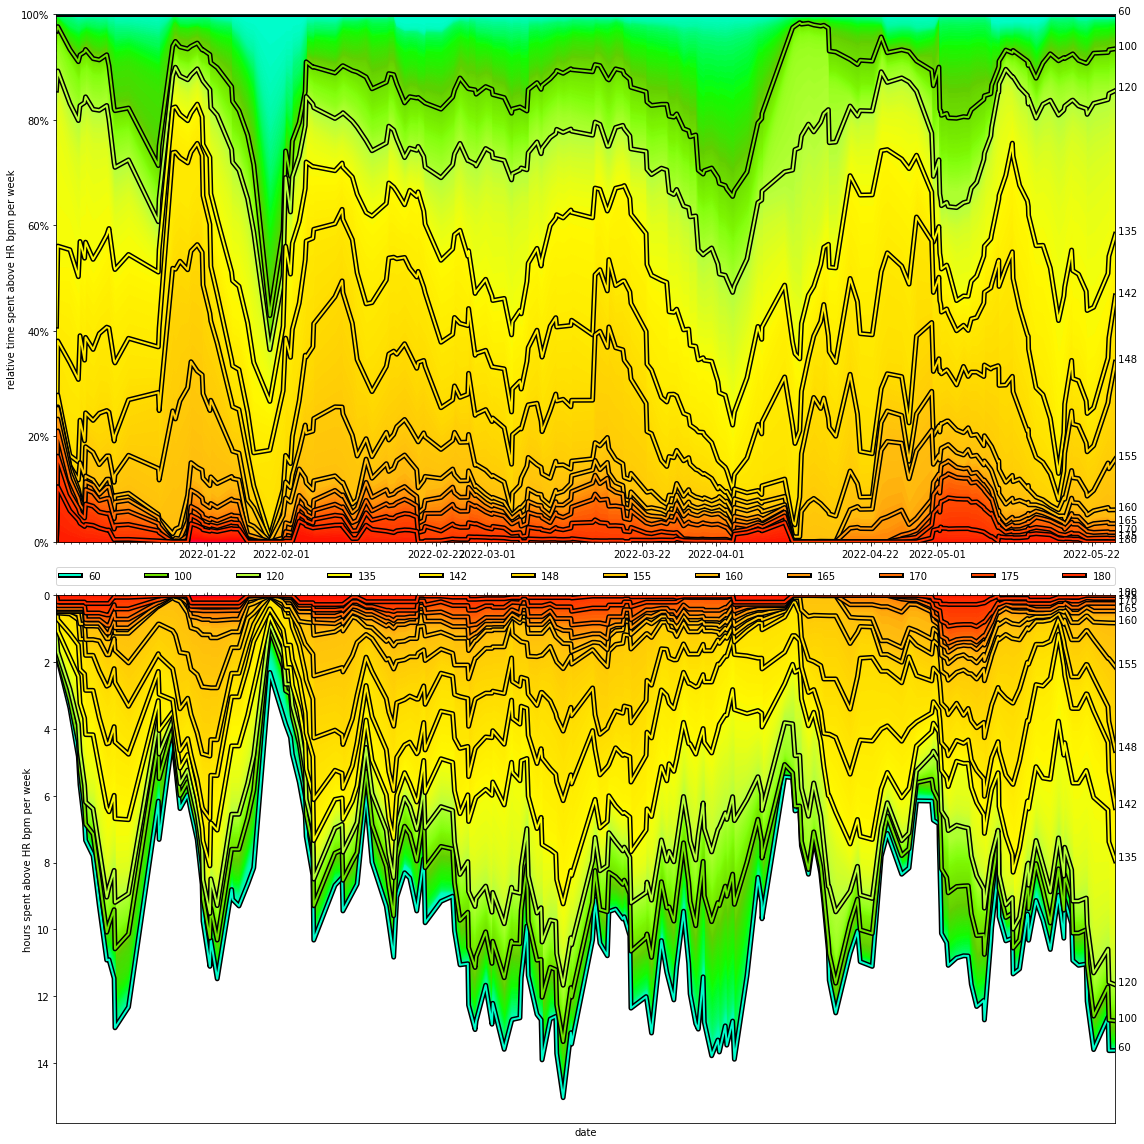

In [10]:
cmap = 'gist_ncar'

rolling_time_above_hr = time_above_hr.loc[
    time_above_hr.index > datetime(2022, 1, 1)
].sort_index().rolling(
    pd.Timedelta(days=7), 
    min_periods=1
).sum()

reltime_above_hr = (
    rolling_time_above_hr / rolling_time_above_hr.values[:, [0]]
)

hr_to_plot = [60, 100, 120, 135, 142, 148, 155, 160, 165, 170, 175, 180]
# hr_to_plot = None 

f, (ax2, ax1) = plt.subplots(2, figsize=(16, 16))
_, _, hr_to_plot = plot_heart_rates(
    rolling_time_above_hr, hrs, hr_to_plot=hr_to_plot, cmap=cmap, ax=ax1)
_, _, hr_to_plot = plot_heart_rates(
    reltime_above_hr * 100, hrs, hr_to_plot=hr_to_plot, cmap=cmap, ax=ax2)

hr_ticks = reltime_above_hr.loc[
    reltime_above_hr.index[-1], hr_to_plot
]

ax1.legend(
    bbox_to_anchor=(0., 1.02, 1., .102), 
    ncol=len(hr_to_plot),
    loc=3, 
    mode="expand",
    borderaxespad=0.
)

xlims = rolling_time_above_hr.index[0], rolling_time_above_hr.index[-1]
ax1.set_xlim(*xlims)
ax2.set_xlim(*xlims)
ax1.xaxis.set_minor_locator(mpl.ticker.FixedLocator(np.arange(*ax1.get_xlim())))
ax2.xaxis.set_minor_locator(mpl.ticker.FixedLocator(np.arange(*ax1.get_xlim())))
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position("top")
ax1.set_xlabel("date")

ax1.set_ylim(rolling_time_above_hr.values.max() * 1.05, 0)
ax1.set_ylabel("hours spent above HR bpm per week")
ax2.set_ylim(0, 100)
ax2.set_ylabel("relative time spent above HR bpm per week")
ax2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

f.tight_layout()